# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [100]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

from scipy import stats

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


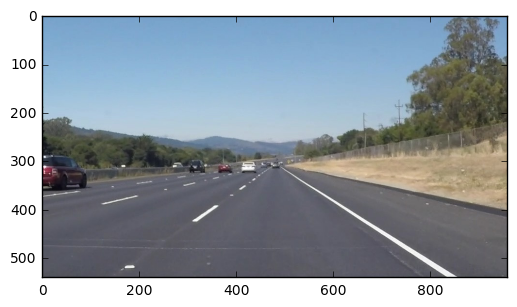

In [101]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image);  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [102]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.95, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# <font color='blue'>Own implementation: Draw Lines</font>

<font color='blue'> This function draws `lines` with `color` and `thickness`.    
<br> Lines are drawn on the image inplace (mutates the image). 
<br> The function first selects lines within a specified range.
    We then seperate left and right lines, and regress on the 
    x,y pairs in order to fit a line-of-best-fit to the data using the lines detected in the last 3 frames.
<br>
<br>    The brightness of the line depends on how well it fits the
    x,y pairs (`r-squared` value). We expect that a line with a 
    very low correlation coefficient will be a bad fit and most
    probably consist of noise (a line fit to noise incorrectly 
    detected as a lane line).
 </font>

In [103]:
left_lines
right_lines
left_slope_values
right_slope_values
left_intercept_values
right_intercept_values

def reset_line_values():
    global left_lines
    global right_lines
    global left_slope_values
    global right_slope_values
    global left_intercept_values
    global right_intercept_values
    
    left_lines = []
    right_lines = []
    left_slope_values = []
    right_slope_values = []
    left_intercept_values = []
    right_intercept_values = []
    
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    global left_lines
    global right_lines
    
    left_line_batch = []
    right_line_batch = []
    
    if lines != None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = (y2-y1)/(x2-x1)
                intercept = y1-slope*x1
                
                # Detect Right Lane Lines, keeping those with slope within 1 std deviation from the previous line slope.
                if slope > 0:
                    is_within_boundaries = True
                    if len(right_intercept_values) > 0 and len(right_slope_values) > 0:
                        if ((abs(slope-right_slope_values[-1]) > np.std(right_slope_values)) 
                        and (abs(intercept-right_intercept_values[-1]) > np.std(right_intercept_values))):
                            is_within_boundaries = False
                            
                    if ((abs(slope) > 0.6 and abs(slope) < 0.8) or is_within_boundaries):
                        right_intercept_values.append(intercept)
                        right_slope_values.append(slope)
                        right_line_batch.append(line)
                
                # Detect Left Lane Lines
                else:
                    is_within_boundaries = True
                    if len(left_intercept_values) > 0 and len(left_slope_values) > 0:
                        if ((abs(slope-left_slope_values[-1]) > np.std(left_slope_values)) 
                        and (abs(intercept-left_intercept_values[-1]) > np.std(left_intercept_values))):
                            is_within_boundaries = False
                            
                    if ((abs(slope) > 0.6 and abs(slope) < 0.8) or is_within_boundaries):
                        left_intercept_values.append(intercept)
                        left_slope_values.append(slope)
                        left_line_batch.append(line)
                        
    left_lines.append(left_line_batch)
    right_lines.append(right_line_batch)
    
    im_height = img.shape[0]
    im_width = img.shape[1]
    
    if len(left_lines) > 0:
    
        xs = []
        ys = []
        
        left_lines.reverse()
        
        for batch in left_lines[:3]:
            for line in batch:
                for x1,y1,x2,y2 in line:
                    xs.extend([x1, x2])
                    ys.extend([y1, y2])
                    
        left_lines.reverse()
        
        if len(xs)>0 and len(ys)>0:
            
            slope, intercept, r_value, p_value, std_err = stats.linregress(xs,ys)

            if slope < np.infty/2 and slope < 0:
                
                lower_x = int((im_height-intercept)/slope)
                higher_y = int(im_height/1.65)
                higher_x = int((higher_y - intercept)/slope)
                
                # Draw the line of best fit, setting the brightness using the correlation coefficient, 
                # such that better lines of fit (of which we are more "sure") are brighter, while 
                # lines with greater error (and hence more noise and uncertainty) are lighter.
                
                cv2.line(img, (lower_x, im_height), (higher_x, higher_y), [0, 0, 255*r_value**2], thickness)

    
    if len(right_lines) > 0:
    
        xs = []
        ys = []
        
        right_lines.reverse()
        
        for batch in right_lines[:3]:
            for line in batch:
                for x1,y1,x2,y2 in line:
                    xs.extend([x1, x2])
                    ys.extend([y1, y2])
                    
        right_lines.reverse()
        
        if len(xs)>0 and len(ys)>0:
            
            slope, intercept, r_value, p_value, std_err = stats.linregress(xs,ys)

            if slope < np.infty/2 and slope > 0:
                
                lower_x = int((im_height-intercept)/slope)
                higher_y = int(im_height/1.65)
                higher_x = int((higher_y - intercept)/slope)
                
                cv2.line(img, (lower_x, im_height), (higher_x, higher_y), [0, 0, 255*r_value**2], thickness)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [104]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg']

In [105]:
def apply_yellow_white_color_mask(image):
    # White Colour Mask
    lower_white = np.array([200, 200, 200], dtype="uint8")*np.sqrt(np.mean(image)/30)
    upper_white = np.array([255, 255, 255], dtype="uint8")
    mask_white = cv2.inRange(image, np.array(lower_white.astype(int)), upper_white.astype(int))
        
    # Yellow Colour Mask
    lower_yellow = np.array([175, 175, 0], dtype="uint8")
    upper_yellow = np.array([255, 255, 175], dtype="uint8")
    mask_yellow_RGB = cv2.inRange(image, lower_yellow.astype(int), upper_yellow.astype(int))
        
    img = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    lower_yellow_HLS = np.array([95, 150, 90], dtype="uint8")
    upper_yellow_HLS = np.array([140, 200, 255], dtype="uint8")
    mask_yellow_HLS = cv2.inRange(img, lower_yellow_HLS.astype(int), upper_yellow_HLS.astype(int))
        
    mask_yellow = cv2.bitwise_and(mask_yellow_HLS, mask_yellow_RGB)
        
    #Add White & Yellow Colour Mask
    mask = cv2.add(mask_yellow, mask_white)
    return cv2.bitwise_and(image, image, mask = mask)

In [106]:
def mask_image_region(image):
    im_height = image.shape[0]
    im_width = image.shape[1]
    
    vertices=np.array([[(im_width*0.2/10, im_height),(im_width/2.1, im_height/1.8), (im_width/1.9, im_height/1.8), (im_width*9.8/10, im_height)]])
    return region_of_interest(img=image, vertices = np.int32(vertices))

/home/gerhard/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/gerhard/anaconda3/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:97: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


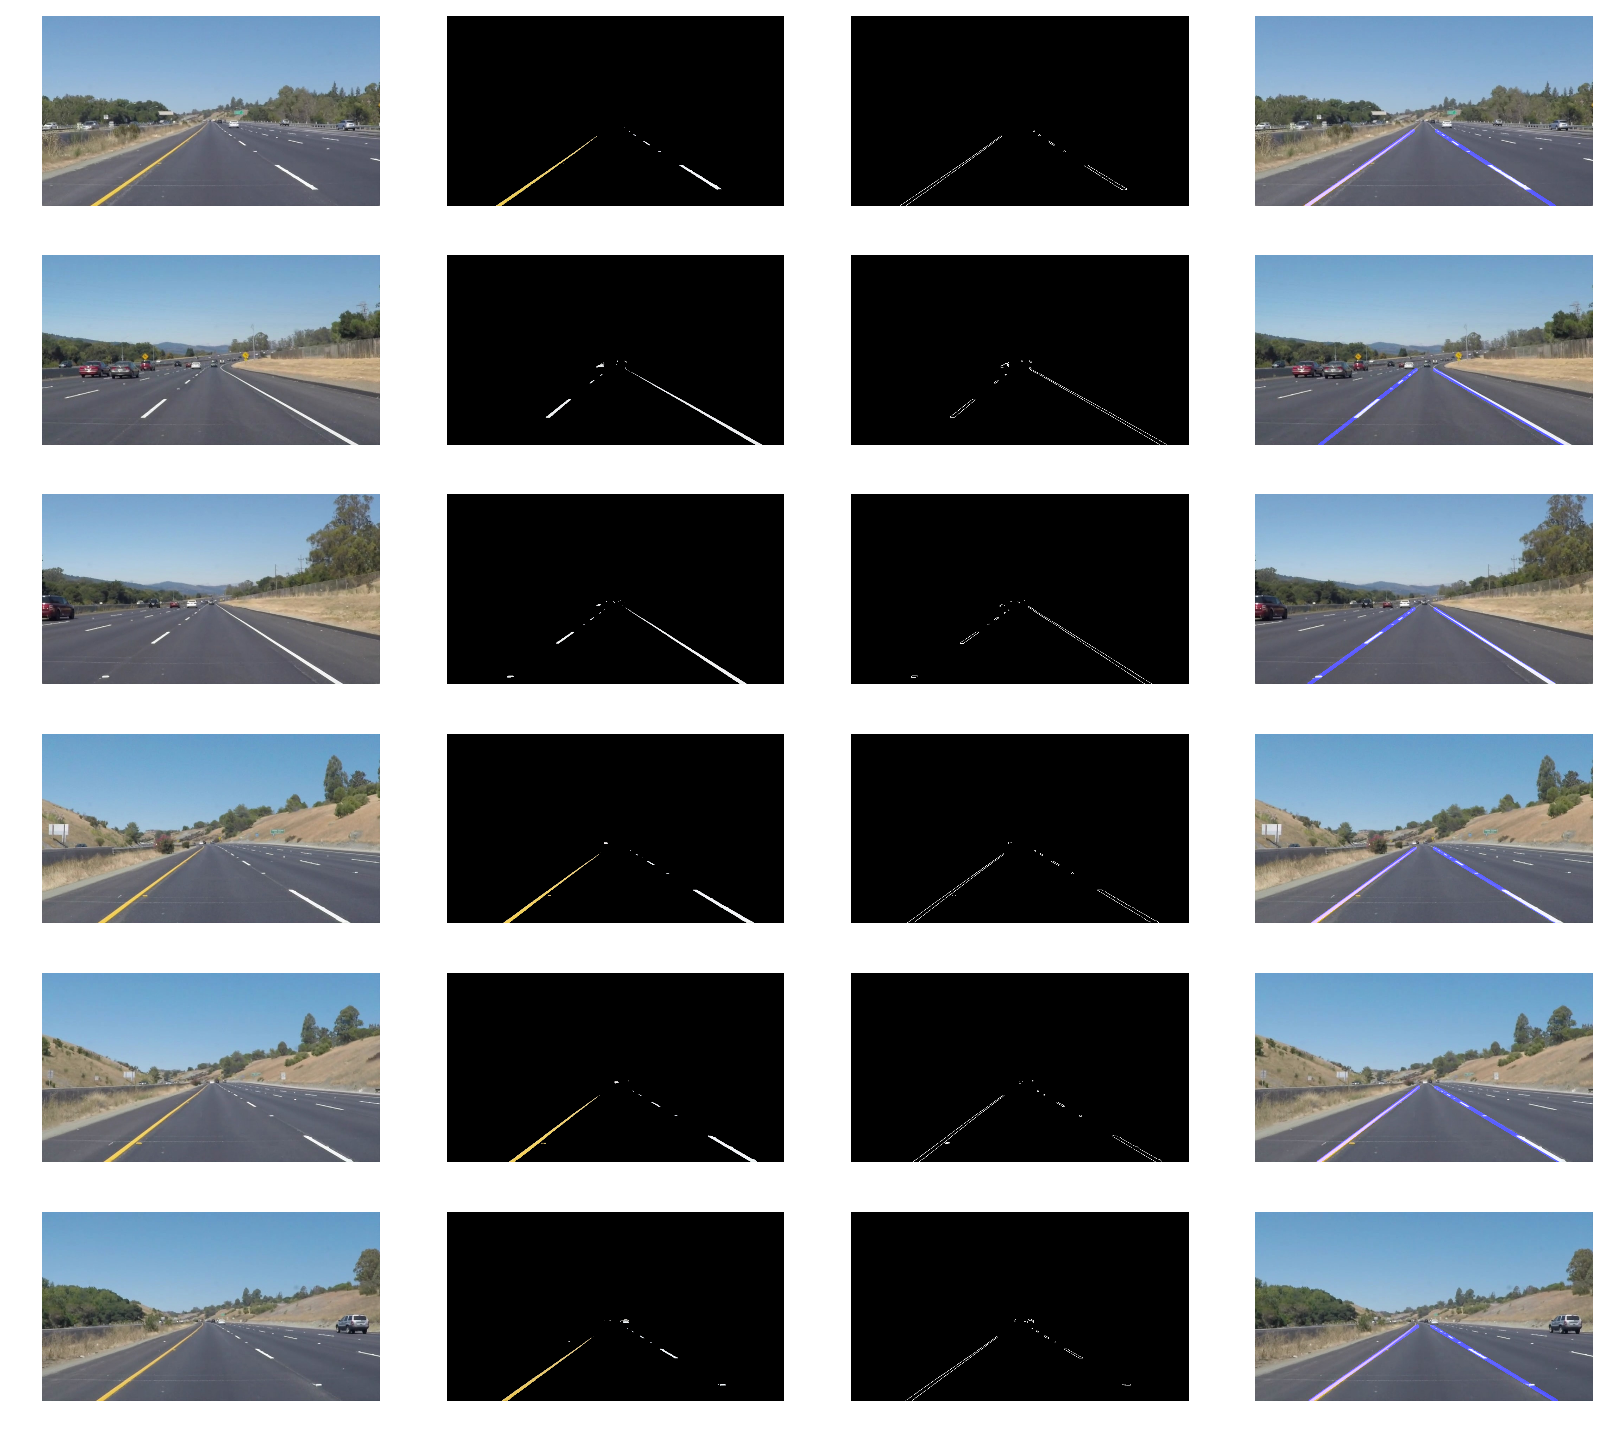

In [107]:
num_images = len(os.listdir("test_images/"))
plt.figure(figsize=(20, num_images*3))

index = 0
for image_dir in os.listdir("test_images/"):
    image = mpimg.imread('test_images/'+image_dir)
    reset_line_values()
    
    # REGION MASK
    region_masked_image = mask_image_region(image)
    
    # YELLOW & WHITE COLOUR MASK
    colour_masked_image = apply_yellow_white_color_mask(region_masked_image)
    
    # GRAYSCALE
    gray_image = grayscale(colour_masked_image)
    
    # BLUR
    kernel_size = 5
    blurred_gray_image = gaussian_blur(gray_image, kernel_size)

    # EDGE DETECTION
    low_threshold = 80
    high_threshold = 270
    image_edges = cv2.Canny(blurred_gray_image, low_threshold, high_threshold)
    
    # LINE DETECTION
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 60
    max_line_gap = 40
    image_lines = hough_lines(img=image_edges, max_line_gap=max_line_gap, min_line_len=min_line_length, rho=rho, theta=theta, threshold=threshold)
    
    # RESULT
    result = weighted_img(image, image_lines)
    
    # PLOTS
    plt.subplot(num_images, 4, index+1)
    plt.imshow(image)
    plt.axis('off')
    
    plt.subplot(num_images, 4, index+2)
    plt.imshow(colour_masked_image)
    plt.axis('off')
    
    plt.subplot(num_images, 4, index+3)
    plt.imshow(image_edges, cmap='gray')
    plt.axis('off')
    
    plt.subplot(num_images, 4, index+4)
    plt.imshow(result)
    plt.axis('off')
    
    # SAVE IMAGE
    plt.imsave("./test_images/RESULT_"+image_dir, result)
    
    index = index + 4
    
plt.show()

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [108]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [109]:
def process_image(image):
    # REGION MASK
    region_masked_image = mask_image_region(image)
    
    # YELLOW & WHITE COLOUR MASK
    colour_masked_image = apply_yellow_white_color_mask(region_masked_image)
    
    # GRAYSCALE
    gray_image = grayscale(colour_masked_image)
    
    # BLUR
    kernel_size = 5
    blurred_gray_image = gaussian_blur(gray_image, kernel_size)

    # EDGE DETECTION
    low_threshold = 80
    high_threshold = 270
    image_edges = cv2.Canny(blurred_gray_image, low_threshold, high_threshold)
    
    # LINE DETECTION
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 60
    max_line_gap = 40
    image_lines = hough_lines(img=image_edges, max_line_gap=max_line_gap, min_line_len=min_line_length, rho=rho, theta=theta, threshold=threshold)
    
    # RESULT
    result = weighted_img(image, image_lines)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [110]:
reset_line_values()

In [111]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


MoviePy: building video file white.mp4
----------------------------------------

Writing video into white.mp4
|----------| 0/213   0% [elapsed: 00:00 left: ?, ? iters/sec]

/home/gerhard/anaconda3/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))
/home/gerhard/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/gerhard/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


|#########-| 204/213  95% [elapsed: 00:11 left: 00:00, 18.45 iters/sec]

/home/gerhard/anaconda3/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:97: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Done writing video in white.mp4 !
Your video is ready !
CPU times: user 27.7 s, sys: 356 ms, total: 28.1 s
Wall time: 12.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [112]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [113]:
reset_line_values()

In [114]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)


MoviePy: building video file yellow.mp4
----------------------------------------

Writing video into yellow.mp4
|----------| 0/654   0% [elapsed: 00:00 left: ?, ? iters/sec]

/home/gerhard/anaconda3/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))
/home/gerhard/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/gerhard/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Done writing video in yellow.mp4 !
Your video is ready !
CPU times: user 1min 28s, sys: 1.37 s, total: 1min 29s
Wall time: 40.8 s


In [115]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### <font color='blue'>How could you imagine making your algorithm better / more robust? </font>

<font color='blue'>At the moment, the algorithm makes use of past frames to analyse whether a "detected" line is probable (within a standard deviation from the previous line).  I do this because - intuitively - we don't expect lane lines to change position much between two consecutive frames. Improving this could involve setting up a probability region, for where we'd expect the line to be. We could then use that to attach high probability to lines falling within the region. 
<br><br>
We could also better use the frames to inform colour selection - which is being done to a degree in my `process_image` function. When the overall brightness of the image is higher, we need to increase the lower brightness threshold for our colour mask (since a road surface and other objects will also tend to be brighter - in addition to the lane lines).  I started implementing this, but with more thorough experimentation and tinkering (and possibly some parameter optimization routine), I could set up an appropriate function to adjust thresholds based on the brightness and contrast of the image.  This will help to filter out unwanted lines and very bright-coloured roads (as in the last challenge).  </font>

### <font color='blue'>Where will your current algorithm be likely to fail? </font>

<font color='blue'>My routines work best on dark roads with clearly defined lane lines.  When lane lines disappear, the algorithms become fragile - similarly, when the road surface changes colour. It will also fail on any different coloured lines - red lines for example (as we have in South Africa). <br><br>  Another critical failiure area will be during lane changes, as it expects lines to fall within a certain boundary, this routine will almost certainly struggle to accurately detect lines during a lane change. Furthermore, the algorithm requires a large open space ahead before the next car.  Being close to a car in front will also confuse the procedure, as it might mistake bright parts of the car for lane lines in addition to the lane lines further down the road not being visible.</font>

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [116]:
reset_line_values()

In [117]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)


MoviePy: building video file extra.mp4
----------------------------------------

Writing video into extra.mp4
|----------| 0/241   0% [elapsed: 00:00 left: ?, ? iters/sec]

/home/gerhard/anaconda3/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))
/home/gerhard/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/gerhard/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


|###-------| 95/241  39% [elapsed: 00:07 left: 00:11, 12.47 iters/sec]

/home/gerhard/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in int_scalars


|####------| 104/241  43% [elapsed: 00:08 left: 00:11, 11.99 iters/sec]

/home/gerhard/anaconda3/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:97: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Done writing video in extra.mp4 !
Your video is ready !
CPU times: user 43 s, sys: 664 ms, total: 43.7 s
Wall time: 25 s


In [118]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))